In [423]:
# Imports
from matplotlib.collections import LineCollection
from matplotlib import cm
import math

import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
#import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
from collections import Counter

from tqdm import tqdm
import pandas as pd

import sys
module_path = 'maze_utils' 
if module_path not in sys.path:
    sys.path.append(module_path)

from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [424]:
# Define and populate the maze structure ma, used as an argument for many functions
ma=NewMaze(6)

# non-valid maze parts
re=[[-0.5,0.5,1,1],[-0.5,4.5,1,1],[-0.5,8.5,1,1],[-0.5,12.5,1,1],
       [2.5,13.5,1,1],[6.5,13.5,1,1],[10.5,13.5,1,1],
       [13.5,12.5,1,1],[13.5,8.5,1,1],[13.5,4.5,1,1],[13.5,0.5,1,1],
       [10.5,-0.5,1,1],[6.5,-0.5,1,1],[2.5,-0.5,1,1],
       [6.5,1.5,1,1],[6.5,11.5,1,1],[10.5,5.5,1,1],[10.5,7.5,1,1],
       [5.5,4.5,1,1],[5.5,8.5,1,1],[7.5,4.5,1,1],[7.5,8.5,1,1],[2.5,5.5,1,1],[2.5,7.5,1,1],
       [-0.5,2.5,3,1],[-0.5,10.5,3,1],[11.5,10.5,3,1],[11.5,2.5,3,1],[5.5,0.5,3,1],[5.5,12.5,3,1],
       [7.5,6.5,7,1]]

In [425]:
# removes consective duplicate coords from a path list of coordinates
def remove_consecutive_duplicate_coords(path):
    return [v for i, v in enumerate(path) if i == 0 or (path[i] != path[i-1]).any()]

In [426]:
# get a path of a bout (list of coordinates)
def get_path_552(nickname,b):
    tf=LoadTraj(nickname+'-tf')
    x=-0.5+15*tf.ke[b][:,0]
    y=-0.5+15*tf.ke[b][:,1]
    t=np.linspace(0,1,x.shape[0]) # time variable
    points_raw = np.array([list(x),list(y)]).transpose().tolist()
    points_no_nan = list(filter(lambda x: (not math.isnan(x[0])) or (not math.isnan(x[1])), points_raw))
    points_rounded = np.array(np.round(points_no_nan), dtype=int)
    points_valid = [x for x in points_rounded if tuple(x) in ma.ce.keys()]
    points_valid = remove_consecutive_duplicate_coords(points_valid)
    #points = [i for (i,j) in zip(points_valid[1:], points_valid) if len(ConnectPath(ma.ce[tuple(j)], ma.ce[tuple(i)], ma))<6]

    new_points = [np.array([0, 7])]
    for next_coord, curr_coord in zip(points_valid[1:], points_valid):
        path_length = len(ConnectPath(ma.ce[tuple(curr_coord)], ma.ce[tuple(next_coord)], ma))
        if path_length<4:
            new_points.append(next_coord)

    points_copy = new_points.copy()
    offset = 0
    for i, (x,y) in enumerate(zip(new_points[1:], new_points)):
        path = ConnectPath(ma.ce[tuple(y)], ma.ce[tuple(x)], ma)
        if len(path)>2:
            coords = []
            for idx in path[1:-1]:
                coords.append(np.array([ma.xc[idx], ma.yc[idx]]))
            points_copy[i+1+offset:i+1+offset] = coords
            offset += len(coords)

    return points_copy, t

In [427]:
# plot a path (list of coordinates) with path coloured based on time
def plot_path_552_time(points, t, ax):
    points = np.array(points).reshape(-1,1,2)

    segs=np.concatenate([points[:-1],points[1:]],axis=1) # array of segments
    lc=LineCollection(segs,cmap=plt.get_cmap('viridis'),linewidths=1.5) # collect segments
    lc.set_array(t) # color the segments by the time variable
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=1,yflip=True,
              xhide=True,yhide=True,axes=ax) # Draw the maze outline    
    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray')
        ax.add_patch(rect)
    ax.axis('off'); # turn off the axes
    ax.add_collection(lc); # add the collection to the plot

In [428]:
# plot a path (list of coordinates) without time
def plot_path_552(points, ax):
    points = np.array(points).reshape(-1,1,2)

    segs=np.concatenate([points[:-1],points[1:]],axis=1) # array of segments
    lc=LineCollection(segs,cmap=plt.get_cmap('viridis'),linewidths=1.5) # collect segments
    lc.set_array(np.linspace(0,1,points.shape[0])) # color the segments
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=1,yflip=True,
              xhide=True,yhide=True,axes=ax) # Draw the maze outline    
    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray')
        ax.add_patch(rect)
    ax.add_collection(lc); # add the collection to the plot
    ax.axis('off'); # turn off the axes

In [429]:
# # get first proper bouts (beyond the first junction) of all 19 animals
# with open('outdata/HomeRuns', 'rb') as f:
#     Names,HR=pickle.load(f) # bout, starting node, node distance, absolute frame   
# sb=[hr[hr[:,2]>1,0][0] for hr in HR] # bout of first home run if past first intersection
# paths, time = [], []
# sb_dict = {}
# for i,nickname in tqdm(enumerate(Names), total=len(Names)):
#     sb_dict[nickname] = sb[i]
#     path, time_var = get_path_552(nickname,sb[i])
#     paths.append(path)
#     time.append(time_var)

In [430]:
# # plot first proper bouts (beyond the first junction) of all 19 animals (with time)
# fig,ax=plt.subplots(4,5,figsize=(12,10))
# for i, path in tqdm(enumerate(paths), total=len(paths)):
#     plot_path_552_time(path, time[i], ax[i//5,i%5])

# lastax=ax[-1,-1] # deal with the last panel
# plot([0],[0],fmts=['w.'],equal=True,yflip=True,
#           xhide=True,yhide=True,axes=lastax) # Draw nothing, helps for some reason 
# lastax.axis('off')
# plt.show()

In [431]:
# # plot first proper bouts (beyond the first junction) of all 19 animals (no time)
# fig,ax=plt.subplots(4,5,figsize=(12,10))
# for i, path in tqdm(enumerate(paths), total=len(paths)):
#     path_no_time = remove_consecutive_duplicate_coords(path)
#     plot_path_552(path_no_time, ax[i//5,i%5])

# lastax=ax[-1,-1] # deal with the last panel
# plot([0],[0],fmts=['w.'],equal=True,yflip=True,
#           xhide=True,yhide=True,axes=lastax) # Draw nothing, helps for some reason 
# lastax.axis('off')
# plt.show()

In [432]:
# this is a mess, but it works. Please don't judge :(
def steps_to_mouse_action(step_list, index_list):
    end_nodes = [idx_list[-1] for idx_list in ma.ru]
    actions = []
    for i, (next_step, curr_step) in enumerate(zip(step_list[1:], step_list)):
        if (next_step == 'node_in' and curr_step == 'node_in') or (next_step == 'node_out' and curr_step == 'node_out'):
            actions.append('straight')
        elif (next_step == 'node_in' and curr_step == 'node_out'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'node_out' and curr_step == 'node_in'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'in left' and curr_step == 'node_in'):
            actions.append('left turn')
        elif (next_step == 'in right' and curr_step == 'node_in'):
            actions.append('right turn')
        elif (next_step == 'in left' and curr_step == 'out left'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'in right' and curr_step == 'out right'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'out left' and curr_step == 'in left'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'out right' and curr_step == 'in right'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'in left' and curr_step == 'out right'):
            actions.append('straight through node')
        elif (next_step == 'in right' and curr_step == 'out left'):
            actions.append('straight through node')
        elif (next_step == 'node_in' and curr_step == 'in left'):
            actions.append('straight')
        elif (next_step == 'node_in' and curr_step == 'in right'):
            actions.append('straight')
        elif (next_step == 'out left' and curr_step == 'node_out'):
            actions.append('straight')
        elif (next_step == 'out right' and curr_step == 'node_out'):
            actions.append('straight')
        elif (next_step == 'node_out' and curr_step == 'out left'):
            actions.append('right turn')
        elif (next_step == 'node_out' and curr_step == 'out right'):
            actions.append('left turn')
        elif (next_step == 'in right' and curr_step == 'in left'):
            actions.append('right turn')
        elif (next_step == 'in left' and curr_step == 'in left'):
            actions.append('left turn')
        elif (next_step == 'in right' and curr_step == 'in right'):
            actions.append('right turn')
        elif (next_step == 'in left' and curr_step == 'in right'):
            actions.append('left turn')
        elif (next_step == 'out left' and curr_step == 'out left'):
            actions.append('right turn')
        elif (next_step == 'out right' and curr_step == 'out right'):
            actions.append('left turn')
        elif (next_step == 'out left' and curr_step == 'out right'):
            actions.append('right turn')
        elif (next_step == 'out right' and curr_step == 'out left'):
            actions.append('left turn')
        else:
            actions.append('NOT HANDLED')

    return actions

In [433]:
# gets a complete list of actions for a path
def get_path_actions(path):
    #convert coordinates to indices
    index_list = [ma.ce[tuple(coord)] for coord in path] 

    # convert indicies to nodes
    # maze.ru is a list of lists, where the inner lists are the indices of the coordinates that are associated to each node
    node_list= []
    for index in index_list:
        for i, node_idx_list in enumerate(ma.ru):
            if index in node_idx_list:
                node_list.append(i)

    # convert nodes to steps
    step_list= []
    for i, (start, end) in enumerate(zip(node_list, node_list[1:])):
        if start == end:
            # travelling inwards along node
            if index_list[i+1] > index_list[i]:
                step_type = 'node_in'
            # travelling outwards along node
            elif index_list[i+1] < index_list[i]:
                step_type = 'node_out'
        else:
            # changing nodes
            step_type = ma.st[start,end]
            
        step_list.append(step_type)

    for i, step_num in enumerate(step_list):
        # in left = 0; in right = 1; out left = 2; out right = 3; illegal = -1
        if step_num == 0:
            step_list[i] = 'in left'
        elif step_num == 1:
            step_list[i] = 'in right'
        elif step_num == 2:
            step_list[i] = 'out left'
        elif step_num == 3:
            step_list[i] = 'out right'

    # convert steps to actions
    return steps_to_mouse_action(step_list, index_list), node_list

In [452]:
def get_path_metrics_df(actions, node_list):
    # get total count of each action
    counts_dict = dict(sorted(dict(Counter(actions)).items()))

    corridor_actions = ['straight', 'turn around']
    node_actions = ['left turn', 'right turn', 'straight through node', 'node turn around']

    corridor_counts = {key: counts_dict[key] for key in counts_dict if key in corridor_actions}
    node_counts = {key: counts_dict[key] for key in counts_dict if key in node_actions}

    # get various counts of the number of actions performed
    total_num_actions = len(actions)
    num_actions_no_dead_ends = total_num_actions - counts_dict['dead end turn around']
    num_actions_corridor = sum([value for value in corridor_counts.values()])
    num_actions_node = sum([value for value in node_counts.values()])

    # get percentages of corridor and node actions
    corridor_percents = {key: round(value/num_actions_corridor*100,2) for key, value in corridor_counts.items()}
    node_percents = {key: round(value/num_actions_node*100,2) for key, value in node_counts.items()}

    # count how many consecutive same turns there are
    turns = [action for action in actions if action in ['left turn', 'right turn']]
    count = 1
    consecutive_same_turns = []
    for next_turn, curr_turn in zip(turns[1:], turns):
        if next_turn == curr_turn:
            count += 1
        else:
            consecutive_same_turns.append(count)
            count = 1
    same_turn_counts = dict(sorted(dict(Counter(consecutive_same_turns)).items()))
    same_turn_percents = {key: round(value*key/(len(turns)-1)*100,2) for key, value in same_turn_counts.items()}

    node_list_cleaned = [next_node for next_node, curr_node in zip(node_list[1:], node_list) if next_node != curr_node]
    node_list_cleaned.insert(0, node_list[0])
    num_nodes_visited = len(node_list_cleaned)
    node_counts = dict(sorted(dict(Counter(node_list_cleaned)).items()))

    return pd.DataFrame({'total # of actions': total_num_actions, '# of actions w/o dead ends': num_actions_no_dead_ends,
                        '# of corridor actions': num_actions_corridor, '# of node actions': num_actions_node,
                        "% of each corridor action": [corridor_percents], "% of each node action": [node_percents],
                        "% of consecutive turn intervals": [same_turn_percents], "total # of unique nodes visisted": num_nodes_visited,
                        "# of visits for visited each node": [node_counts]})

In [453]:
# example of using the above functions
path, _ = get_path_552('B1', 13)
actions, node_list = get_path_actions(path)
metrics_df = get_path_metrics_df(actions, node_list)

In [451]:
metrics_df

,total # of actions,# of actions w/o dead ends,# of corridor actions,# of node actions,% of each corridor action,% of each node action,% of same turn intervals,total # of unique nodes visisted,# of visits for visited each node
0,147,138,78,60,"{'straight': 51.28, 'turn around': 48.72}","{'left turn': 20.0, 'node turn around': 35.0, ...","{0: 12.0, 1: 36.0, 2: 4.0}",81,"{0: 10, 1: 6, 2: 11, 5: 13, 6: 3, 11: 5, 12: 5..."


# Next steps:
1. only get rewarded mice (10 of them)
2. get paths of all rewarded mice past first intersection (done below, but not yet separated by reward vs. non-reward)
3. cut the paths off if they reach index 165, otherwise let the paths go until they exit
4. get metric for how many nodes they visit before reaching the reward
5. get metric for how many times they visit a node


In [234]:
with open('outdata/HomeRuns', 'rb') as f:
    Names,HR=pickle.load(f) # bout, starting node, node distance, absolute frame   
sb=[hr[hr[:,2]>1,0] for hr in HR] # bout of first home run if past first intersection
bout_dict = {}
for mouse, sb_list in zip(Names, sb):
    bout_dict[mouse] = sb_list

In [399]:
#for bout in range(len)
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
for name in RewNames:
    tf=LoadTraj(f'{name}-tf')
    for bout in range(len(tf.ke)):
        path, _ = get_path_552(name, bout)
    

<AxesSubplot:>

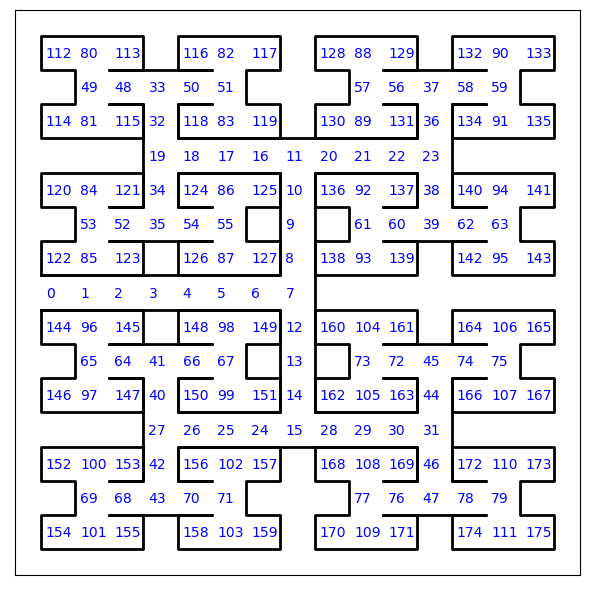

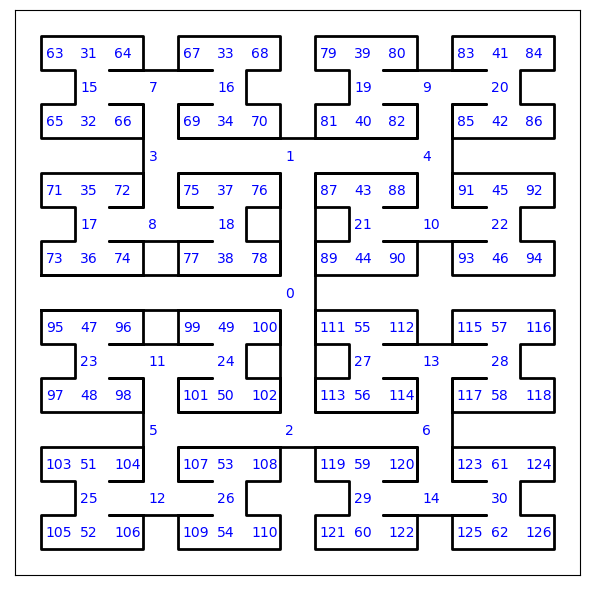

In [420]:
PlotMazeCells(ma)
PlotMazeNodes(ma)